### 연도가 지남에 따른 고령자 사고 발생 수 증가 추세 여부

귀무가설(H0): 연도에 따라 고령자 사고 피해 수는 변화가 없다.
<br>
<br>
대립가설(H1): 연도에 따라 고령자 사고 피해 수는 변화가 있다.

In [1]:
# 라이브러리 호출 및 plot 설정
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML
from scipy.stats import f_oneway, chi2_contingency
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings("ignore")

In [2]:
df_total = pd.read_csv('../../data/preprocessed_data/시도_시군구별_보행자_사고_사고유형_전처리ver.csv')
# df_total.head()
HTML(df_total.head().to_html())

,연도,시군구,법정동코드,사고내용,사망자수,중상자수,경상자수,부상신고자수,사고유형,도로형태,피해자 상해정도
0,2020,서울특별시 종로구 창성동,1111010500,중상사고,0,1,0,0,차대사람 - 차도통행중,교차로 - 교차로부근,중상
1,2020,서울특별시 종로구 창성동,1111010500,중상사고,0,1,0,0,차대사람 - 차도통행중,교차로 - 교차로안,중상
2,2020,서울특별시 종로구 통인동,1111010800,경상사고,0,0,1,0,차대사람 - 기타,단일로 - 기타,경상
3,2020,서울특별시 종로구 누상동,1111010900,경상사고,0,0,1,0,차대사람 - 차도통행중,교차로 - 교차로안,경상
4,2020,서울특별시 종로구 누상동,1111010900,경상사고,0,0,1,0,차대사람 - 기타,단일로 - 기타,경상


In [ ]:
# 조건 입력을 통해 피해자 유형별 합계 추산
def summarize_injury_by_conditions(df, **conditions):
    """
    입력된 조건(포함 조건 포함)에 따라 사망자수, 중상자수, 경상자수, 부상신고자수 합계를 반환.
    예: summarize_injury_by_conditions(df, 연도=2020, 시군구='서울특별시')
    """
    filtered_df = df.copy()

    for column, value in conditions.items():
        if column == '법정동코드_5자리':
            filtered_df = filtered_df[filtered_df['법정동코드'].astype(str).str.startswith(str(value))]
        elif column in df.columns:
            if pd.api.types.is_numeric_dtype(df[column]):
                filtered_df = filtered_df[filtered_df[column] == value]
            else:
                filtered_df = filtered_df[filtered_df[column].astype(str).str.contains(str(value))]

    # 합계 계산
    summary = {
        '사망자수': int(filtered_df['사망자수'].sum()),
        '중상자수': int(filtered_df['중상자수'].sum()),
        '경상자수': int(filtered_df['경상자수'].sum()),
        '부상신고자수': int(filtered_df['부상신고자수'].sum())
    }
    total = int(filtered_df['사망자수'].sum() + filtered_df['중상자수'].sum() + filtered_df['경상자수'].sum() + filtered_df['부상신고자수'].sum())

    print(f"\n적용된 조건: {conditions}")
    print(f"▶ 사망자수: {summary['사망자수']}명")
    print(f"▶ 중상자수: {summary['중상자수']}명")
    print(f"▶ 경상자수: {summary['경상자수']}명")
    print(f"▶ 부상신고자수: {summary['부상신고자수']}명")
    print(f"▶ 총 피해자 수: {total}건\n")

    return summary

In [4]:
summarize_injury_by_conditions(df_total, 사고유형='차대사람 - 횡단중')


적용된 조건: {'사고유형': '차대사람 - 횡단중'}
▶ 사망자수: 1494명
▶ 중상자수: 11910명
▶ 경상자수: 6449명
▶ 부상신고자수: 529명
▶ 총 피해자 수: 20382건



{'사망자수': 1494, '중상자수': 11910, '경상자수': 6449, '부상신고자수': 529}

In [8]:
summarize_injury_by_conditions(df_total, 시군구='경기도 수원시')


적용된 조건: {'시군구': '경기도 수원시'}
▶ 사망자수: 35명
▶ 중상자수: 493명
▶ 경상자수: 479명
▶ 부상신고자수: 55명
▶ 총 피해자 수: 1062건



{'사망자수': 35, '중상자수': 493, '경상자수': 479, '부상신고자수': 55}

In [9]:
# 기존 함수에서 print만 주석 처리
def summarize_injury_by_conditions(df, **conditions):
    """
    입력된 조건(포함 조건 포함)에 따라 사망자수, 중상자수, 경상자수, 부상신고자수 합계를 반환.
    예: summarize_injury_by_conditions(df, 연도=2020, 시군구='서울특별시')
    """
    filtered_df = df.copy()

    for column, value in conditions.items():
        if column == '법정동코드_5자리':
            filtered_df = filtered_df[filtered_df['법정동코드'].astype(str).str.startswith(str(value))]
        elif column in df.columns:
            if pd.api.types.is_numeric_dtype(df[column]):
                filtered_df = filtered_df[filtered_df[column] == value]
            else:
                filtered_df = filtered_df[filtered_df[column].astype(str).str.contains(str(value))]

    # 합계 계산
    summary = {
        '사망자수': int(filtered_df['사망자수'].sum()),
        '중상자수': int(filtered_df['중상자수'].sum()),
        '경상자수': int(filtered_df['경상자수'].sum()),
        '부상신고자수': int(filtered_df['부상신고자수'].sum())
    }

    # print(f"\n적용된 조건: {conditions}")
    # print(f"▶ 사망자수: {summary['사망자수']}명")
    # print(f"▶ 중상자수: {summary['중상자수']}명")
    # print(f"▶ 경상자수: {summary['경상자수']}명")
    # print(f"▶ 부상신고자수: {summary['부상신고자수']}명")
    # print(f"▶ 총 피해자 수: {len(filtered_df)}건\n")

    return summary

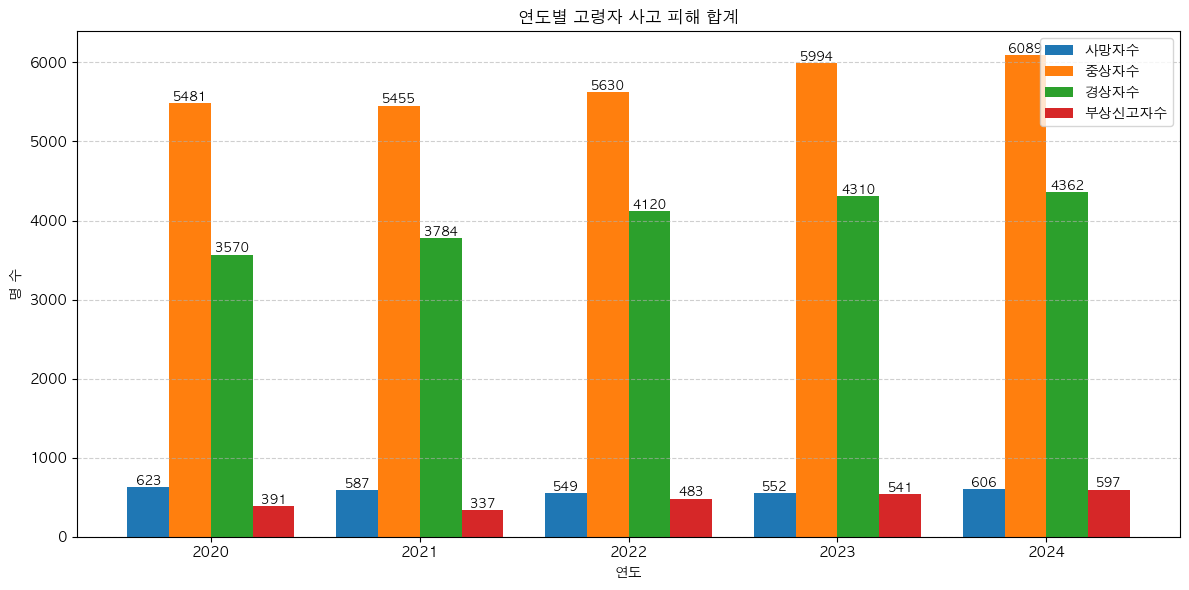

In [10]:
# 데이터 수집
years = [2020, 2021, 2022, 2023, 2024]
death_counts = []
serious_counts = []
minor_counts = []
report_counts = []

for year in years:
    summary = summarize_injury_by_conditions(df_total, 연도=year)
    death_counts.append(summary['사망자수'])
    serious_counts.append(summary['중상자수'])
    minor_counts.append(summary['경상자수'])
    report_counts.append(summary['부상신고자수'])

# 시각화
plt.figure(figsize=(12, 6))
bar_width = 0.2
x = range(len(years))

# 각 막대 생성
bars1 = plt.bar([i - 1.5*bar_width for i in x], death_counts, width=bar_width, label='사망자수')
bars2 = plt.bar([i - 0.5*bar_width for i in x], serious_counts, width=bar_width, label='중상자수')
bars3 = plt.bar([i + 0.5*bar_width for i in x], minor_counts, width=bar_width, label='경상자수')
bars4 = plt.bar([i + 1.5*bar_width for i in x], report_counts, width=bar_width, label='부상신고자수')

# 수치 표시 함수
def add_bar_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{height}', 
                 ha='center', va='bottom', fontsize=9)

# 수치 추가
add_bar_labels(bars1)
add_bar_labels(bars2)
add_bar_labels(bars3)
add_bar_labels(bars4)

# 그래프 꾸미기
plt.xticks(x, years)
plt.title('연도별 고령자 사고 피해 합계')
plt.xlabel('연도')
plt.ylabel('명 수')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# 이미지 저장
# save_path = '../../outputs/가설_1/연도별_고령자_사고_피해_합계.png'
# plt.savefig(save_path)

In [ ]:
# 연도별 합계 데이터프레임 생성
injury_summary = []

for year in [2020, 2021, 2022, 2023, 2024]:
    summary = summarize_injury_by_conditions(df_total, 연도=year)
    summary['연도'] = year
    injury_summary.append(summary)

df_injury = pd.DataFrame(injury_summary)
df_injury = df_injury[['연도', '사망자수', '중상자수', '경상자수', '부상신고자수']]

# ANOVA 검정
groups = [df_total[df_total['연도'] == year]['경상자수'] for year in [2020, 2021, 2022, 2023, 2024]]
f_stat, p_val = f_oneway(*groups)
print(f"F-통계량: {f_stat:.4f}, p-value: {p_val:.4f}")

# ==========================================
# 연도 간 차이가 무작위(우연)보다 약 4.6배 큼
# p-value < 0.05이므로 귀무가설 기각
# 연도에 따라 고령자 사고 피해 수에 유의미한 차이 존재
# ==========================================

F-통계량: 4.5946, p-value: 0.0010


### 번외 시계열 예측

In [ ]:
# ============    번 외     ============

# 귀무가설(H0): 연도와 피해 유형간의 연관성이 없다.
# 대립가설(H1): 연도와 피해 유형간의 연관성이 있다.

# 연도 vs 피해유형 피벗 테이블 생성
df_cross = pd.pivot_table(
    df_total,
    values='사망자수', 
    index='연도', 
    aggfunc='sum'
).join([
    df_total.pivot_table(values='중상자수', index='연도', aggfunc='sum'),
    df_total.pivot_table(values='경상자수', index='연도', aggfunc='sum'),
    df_total.pivot_table(values='부상신고자수', index='연도', aggfunc='sum')
])

chi2, p_val, dof, expected = chi2_contingency(df_cross)
print(f"Chi-square: {chi2:.4f}, p-value: {p_val:.15f}")

# =========================================================
# 2020년과 2024년 사이, 고령자 교통사고에서의 피해유형 분포가 변했을까?
# Chi-square: 94.2524 -> 연도와 피해 유형간의 연관성이 매우 크다
# p-value < 0.05이므로 귀무가설 기각
# 피해 유형별로 연도에 따른 분포 차이가 유의미하게 존재한다.
# 피해의 종류(사망/중상/경상 등) 측면에서도 연도에 따라 달라진다.
# =========================================================

Chi-square: 94.2524, p-value: 0.000000000000007


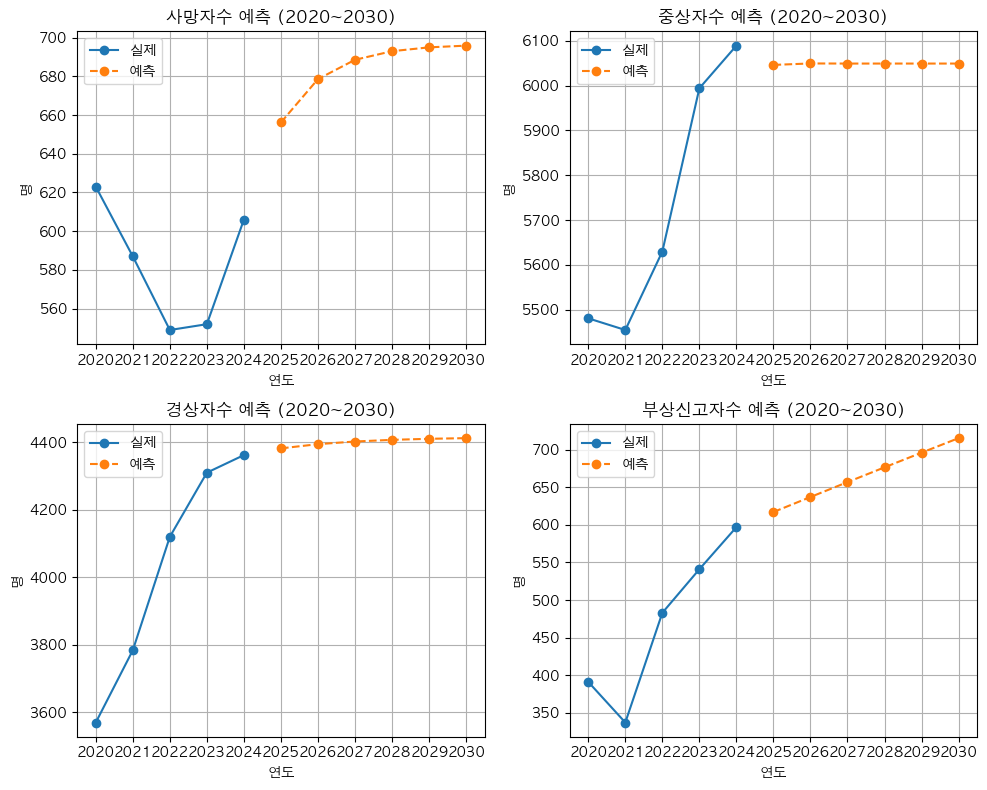

In [14]:
# 연도별 합계 데이터프레임 구성
summary_by_year = []
for year in range(2020, 2025):
    result = summarize_injury_by_conditions(df_total, 연도=year)
    result['연도'] = year
    summary_by_year.append(result)
df_summary = pd.DataFrame(summary_by_year).set_index('연도')

# 예측 및 시각화 함수
def forecast_and_plot(df_summary, column):
    model = SARIMAX(df_summary[column], order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
    results = model.fit(disp=False)
    forecast = results.predict(start=len(df_summary), end=len(df_summary) + 5)
    years = list(df_summary.index) + list(range(2025, 2031))
    values = list(df_summary[column]) + list(forecast)

    plt.plot(years[:len(df_summary)], df_summary[column], marker='o', label='실제')
    plt.plot(years[len(df_summary):], forecast, marker='o', linestyle='--', label='예측')
    plt.title(f"{column} 예측 (2020~2030)")
    plt.xlabel("연도")
    plt.ylabel("명")
    plt.grid(True)
    plt.legend()
    plt.xticks(years)

# 시각화 실행
plt.figure(figsize=(10, 8))
for i, col in enumerate(['사망자수', '중상자수', '경상자수', '부상신고자수']):
    plt.subplot(2, 2, i+1)
    forecast_and_plot(df_summary, col)

plt.tight_layout()
plt.show()

# 이미지 저장
# save_path = "../../outputs/가설_1/피해별_인원_예측(2020~2030).png"
# plt.savefig(save_path)

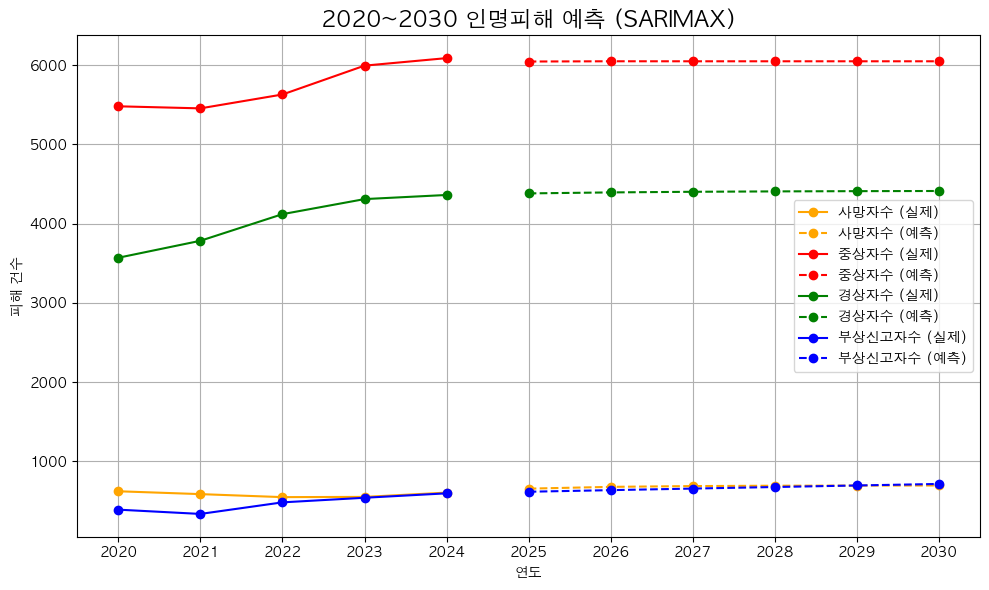

In [ ]:
summary_by_year = []
for year in range(2020, 2025):
    result = summarize_injury_by_conditions(df_total, 연도=year)
    result['연도'] = year
    summary_by_year.append(result)

df_summary = pd.DataFrame(summary_by_year).set_index('연도')

plt.figure(figsize=(10, 6))
colors = ['orange', 'red', 'green', 'blue']
columns = ['사망자수', '중상자수', '경상자수', '부상신고자수']

for i, col in enumerate(columns):
    # 모델 적합 및 예측
    model = SARIMAX(df_summary[col], order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
    results = model.fit(disp=False)
    forecast = results.predict(start=len(df_summary), end=len(df_summary) + 5)

    # 연도 축
    years = list(df_summary.index) + list(range(2025, 2031))
    actual = list(df_summary[col])
    predicted = list(forecast)

    # 그래프 그리기
    plt.plot(df_summary.index, actual, marker='o', color=colors[i], label=f"{col} (실제)")
    plt.plot(range(2025, 2031), predicted, marker='o', linestyle='--', color=colors[i], label=f"{col} (예측)")

plt.title("2020~2030 인명피해 예측 (SARIMAX)", fontsize=16)
plt.xlabel("연도")
plt.ylabel("피해 건수")
plt.xticks(list(range(2020, 2031)))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 이미지 저장
# save_path = '../../outputs/2020~2030 인명피해 예측 (SARIMAX).png'
# plt.savefig(save_path)